In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene
from scipy.stats import shapiro
from scipy.stats import norm
import seaborn as sns

In [2]:
#loading csv file
df = pd.read_csv("Datasets/Vaccination_Coverage_among_Young_Children__0-35_Months__20241101.csv")

#dropping columns
df = df.drop(columns=['Geography Type'])

#filtering DF again to keep only rows where Dimension Type = 'Age' 
df = df[df['Dimension Type'] == 'Age']

#sorting by vaccine type (column is named 'Vaccine')
df_sorted = df.sort_values (by='Vaccine')

#Displaying the sorted DataFrame
df_sorted

df


,Vaccine,Dose,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
0,DTaP,≥3 Doses,North Dakota,2019,Age,19 Months,93.5,88.0 to 96.6,263.0
1,DTaP,≥3 Doses,North Dakota,2018,Age,19 Months,95.2,91.0 to 97.5,293.0
2,DTaP,≥3 Doses,North Dakota,2018-2019,Age,19 Months,91.8,88.3 to 94.3,556.0
3,Polio,≥3 Doses,North Dakota,2021,Age,19 Months,89.4,81.9 to 94.1,143.0
4,Polio,≥2 Doses,North Dakota,2021,Age,5 Months,79.3,69.0 to 86.8,143.0
...,...,...,...,...,...,...,...,...,...
128183,Hep A,≥2 Doses,New Hampshire,2021,Age,24 Months,46.7,36.7 to 58.0,126.0
128184,DTaP,≥3 Doses,New Hampshire,2021,Age,19 Months,95.0,90.2 to 97.5,126.0
128185,Hep B,≥3 Doses,New Hampshire,2020-2021,Age,24 Months,95.5,92.5 to 97.5,315.0
128186,PCV,≥3 Doses,New Hampshire,2021,Age,7 Months,70.0,59.6 to 78.7,126.0


In [3]:
# Defining a dictionary to map each state to respective region
#expanding from original 4 regions to 9 regions: 
    #Pacific West, Mountain West, West North Central, East North Central, East South Central 
    # West South Central, South Atlantic, Middle Atlantic, New England
state_to_region = {
    # Middle Atlantic
    'New York': 'Middle Atlantic', 'NY-Rest of state': 'Middle Atlantic', 'NY-City of New York': 'Middle Atlantic', 
    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic', 
    'PA-Philadelphia': 'Middle Atlantic', 'PA-Rest of state': 'Middle Atlantic',

    # New England
    'Vermont': 'New England', 'New Hampshire': 'New England', 'Massachusetts': 'New England', 
    'Connecticut': 'New England', 'Rhode Island': 'New England', 'Maine': 'New England',

    # East North Central
    'Indiana': 'East North Central', 'Illinois': 'East North Central', 'Michigan':'East North Central', 'Ohio': 'East North Central', 
    'Wisconsin': 'East North Central', 'IL-City of Chicago': 'East North Central', 
    'IL-Rest of state': 'East North Central',

    # West North Central
    'Iowa': 'West North Central', 'Kansas': 'West North Central', 'Minnesota': 'West North Central',
    'Missouri': 'West North Central', 'Nebraska': 'West North Central', 'North Dakota': 'West North Central', 
    'South Dakota': 'West North Central',

    #South Atlantic
    'Delaware': 'South Atlantic', 'District of Columbia': 'South Atlantic', 'Florida': 'South Atlantic', 
    'Georgia': 'South Atlantic', 'Maryland': 'South Atlantic', 'North Carolina': 'South Atlantic', 'South Carolina': 'South Atlantic',
    'Virginia': 'South Atlantic', 'West Virginia': 'South Atlantic',

    #East South Central
    'Alabama': 'East South Central', 'Kentucky': 'East South Central', 'Mississippi': 'East South Central', 
    'Tennessee': 'East South Central', 

    #West South Central
    'Arkansas': 'West South Central', 'Louisiana': 'West South Central', 'Oklahoma': 'West South Central', 
    'Texas': 'West South Central', 'TX-City of Houston': 'West South Central', 'TX-Rest of state': 'West South Central',
    'TX-Dallas County': 'West South Central', 'TX-Bexar County':'West South Central', 'TX-El Paso County': 'West South Central',
    'TX-Hidalgo County': 'West South Central', 'TX-Tarrant County':'West South Central',

    #Mountain 
    'Arizona': 'Mountain', 'Colorado': 'Mountain', 'Idaho':'Mountain', 'New Mexico':'Mountain', 
    'Montana': 'Mountain', 'Utah':'Mountain', 'Nevada': 'Mountain', 'Wyoming': 'Mountain',

    #Pacific
    'Alaska': 'Pacific', 'California': 'Pacific', 'Hawaii': 'Pacific', 'Oregon': 'Pacific',
    'Washington': 'Pacific'
}

# Mapping each state in the 'Geography' column to its region
df['Region'] = df['Geography'].map(state_to_region)

# Reordering columns so that 'Region' appears first
df = df[['Region'] + [col for col in df.columns if col != 'Region']]

# Display the updated DataFrame
df



,Region,Vaccine,Dose,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size
0,West North Central,DTaP,≥3 Doses,North Dakota,2019,Age,19 Months,93.5,88.0 to 96.6,263.0
1,West North Central,DTaP,≥3 Doses,North Dakota,2018,Age,19 Months,95.2,91.0 to 97.5,293.0
2,West North Central,DTaP,≥3 Doses,North Dakota,2018-2019,Age,19 Months,91.8,88.3 to 94.3,556.0
3,West North Central,Polio,≥3 Doses,North Dakota,2021,Age,19 Months,89.4,81.9 to 94.1,143.0
4,West North Central,Polio,≥2 Doses,North Dakota,2021,Age,5 Months,79.3,69.0 to 86.8,143.0
...,...,...,...,...,...,...,...,...,...,...
128183,New England,Hep A,≥2 Doses,New Hampshire,2021,Age,24 Months,46.7,36.7 to 58.0,126.0
128184,New England,DTaP,≥3 Doses,New Hampshire,2021,Age,19 Months,95.0,90.2 to 97.5,126.0
128185,New England,Hep B,≥3 Doses,New Hampshire,2020-2021,Age,24 Months,95.5,92.5 to 97.5,315.0
128186,New England,PCV,≥3 Doses,New Hampshire,2021,Age,7 Months,70.0,59.6 to 78.7,126.0


In [4]:
# Filter the DataFrame to only include rows where:
# - 'Vaccine' is 'DTaP' and 'MMR'
# - 'Birth Cohort' is '2020-2021'
# - 'Age Group' includes 19 months, 24 months, and 35 months: all ages where it can be safely assumed that individual 
#   is not age-restricted from receiving most up-to-date dosages of each vaccine (4 doses for DTaP, 1 dose for MMR)

# Create df_filtered based on conditions above
df_filtered = df[
    (df['Vaccine'].isin(['DTaP','≥1 Dose MMR'])) &
    (df['Birth Year/Birth Cohort'].isin(['2020-2021', '2020', '2021'])) &
 
   (df['Dimension'].isin(['19 Months','24 Months','35 Months'])) &
   (
        ((df['Vaccine'] == 'DTaP') & (df['Dose'] == '≥4 Doses')) | 
        (df['Vaccine'] == '≥1 Dose MMR')
    )
]

# Rename the column 'Estimate (%)' to 'Estimated Percentage' in df_filtered
df_filtered = df_filtered.rename(columns={'Estimate (%)': 'Estimated_Percentage'})

# Exclude rows where 'Region' , 'Percentage', 'Vaccine' is NaN
df_filtered = df_filtered.dropna(subset=['Region', 'Vaccine', 'Estimated_Percentage'])


df_filtered


,Region,Vaccine,Dose,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimated_Percentage,95% CI (%),Sample Size
11,West North Central,≥1 Dose MMR,NaN,North Dakota,2021,Age,19 Months,79.9,69.5 to 87.3,143.0
23,West North Central,DTaP,≥4 Doses,North Dakota,2021,Age,35 Months,77.2,67.0 to 86.1,143.0
44,West North Central,≥1 Dose MMR,NaN,North Dakota,2020-2021,Age,35 Months,91.0,85.0 to 95.2,391.0
51,West North Central,DTaP,≥4 Doses,North Dakota,2020-2021,Age,19 Months,68.8,61.8 to 75.1,391.0
65,West North Central,≥1 Dose MMR,NaN,North Dakota,2020-2021,Age,19 Months,83.8,77.6 to 88.5,391.0
...,...,...,...,...,...,...,...,...,...,...
127971,New England,≥1 Dose MMR,NaN,New Hampshire,2020,Age,19 Months,94.4,88.3 to 97.4,189.0
128165,New England,DTaP,≥4 Doses,New Hampshire,2021,Age,24 Months,89.1,80.1 to 95.2,126.0
128168,New England,≥1 Dose MMR,NaN,New Hampshire,2021,Age,24 Months,96.6,93.2 to 98.6,126.0
128172,New England,DTaP,≥4 Doses,New Hampshire,2020-2021,Age,35 Months,94.6,91.2 to 97.1,315.0


In [5]:
#Confirming conditions met to conduct an ANOVA test:

#1. Equal Variance / Normal Distribution for Regions and MMR


grouped_data = [df_filtered[df_filtered['Region'] == region]['Estimated_Percentage'] for region in df_filtered['Region'].unique()]
stat, p_value = levene(*grouped_data)

print(f"Levene's Test Statistic 1: {stat:.2f}, p-value: {p_value:.4f}")
if p_value > 0.01:
    print("Equal variance assumption is met.")
else:
    print("Equal variance assumption is violated.")



# Region x Vaccine Normal Distribution Test: Shapiro-Wilk (MMR)

mmr_region_data = df_filtered[df_filtered['Vaccine'] == '≥1 Dose MMR']

# Loop through each unique region and perform the Shapiro-Wilk test
for region in mmr_region_data['Region'].unique():
    region_data = mmr_region_data[mmr_region_data['Region'] == region]['Estimated_Percentage']
    stat, p_value = shapiro(region_data)
    
    print(f"Region: {region}")
    print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.01:
        print("Data is normally distributed.\n")
    else:
        print("Data is not normally distributed.\n")



Levene's Test Statistic 1: 1.48, p-value: 0.1585
Equal variance assumption is met.
Region: West North Central
Shapiro-Wilk Test Statistic: 0.9623, p-value: 0.0511
Data is normally distributed.

Region: South Atlantic
Shapiro-Wilk Test Statistic: 0.9759, p-value: 0.1294
Data is normally distributed.

Region: Middle Atlantic
Shapiro-Wilk Test Statistic: 0.9639, p-value: 0.0618
Data is normally distributed.

Region: East North Central
Shapiro-Wilk Test Statistic: 0.9749, p-value: 0.2251
Data is normally distributed.

Region: West South Central
Shapiro-Wilk Test Statistic: 0.9759, p-value: 0.2520
Data is normally distributed.

Region: Mountain
Shapiro-Wilk Test Statistic: 0.9806, p-value: 0.3305
Data is normally distributed.

Region: East South Central
Shapiro-Wilk Test Statistic: 0.9682, p-value: 0.3783
Data is normally distributed.

Region: New England
Shapiro-Wilk Test Statistic: 0.9901, p-value: 0.9352
Data is normally distributed.

Region: Pacific
Shapiro-Wilk Test Statistic: 0.9696, 

In [6]:
#2. Equal Variance / Normal Distribution for Regions and DTaP

# Filter the dataframe for 'DTaP' vaccine only
dtap_data = df_filtered[df_filtered['Vaccine'] == 'DTaP']

# Group the data by 'Region' for Levene's test
grouped_dtap_data = [dtap_data[dtap_data['Region'] == region]['Estimated_Percentage'] for region in dtap_data['Region'].unique()]

# Conduct Levene's test for equal variance
stat, p_value = levene(*grouped_dtap_data)

print(f"Levene's Test Statistic: {stat:.2f}, p-value: {p_value:.4f}")
if p_value > 0.01:
    print("Equal variance assumption is met.")
else:
    print("Equal variance assumption is violated.")




# Region x Vaccine Normal Distribution Test: Shapiro-Wilk (DTaP)

dtap_region_data = df_filtered[df_filtered['Vaccine'] == 'DTaP']

# Loop through each unique region and perform the Shapiro-Wilk test
for region in dtap_region_data['Region'].unique():
    regions_data = dtap_region_data[dtap_region_data['Region'] == region]['Estimated_Percentage']
    stat, p_value = shapiro(regions_data)
    
    print(f"Region: {region}")
    print(f"Shapiro-Wilk Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.01:
        print("Data is normally distributed.\n")
    else:
        print("Data is not normally distributed.\n")




Levene's Test Statistic: 0.57, p-value: 0.8003
Equal variance assumption is met.
Region: West North Central
Shapiro-Wilk Test Statistic: 0.9853, p-value: 0.6567
Data is normally distributed.

Region: South Atlantic
Shapiro-Wilk Test Statistic: 0.9826, p-value: 0.3390
Data is normally distributed.

Region: Middle Atlantic
Shapiro-Wilk Test Statistic: 0.9324, p-value: 0.0019
Data is not normally distributed.

Region: East North Central
Shapiro-Wilk Test Statistic: 0.9748, p-value: 0.2225
Data is normally distributed.

Region: West South Central
Shapiro-Wilk Test Statistic: 0.9815, p-value: 0.4624
Data is normally distributed.

Region: Mountain
Shapiro-Wilk Test Statistic: 0.9773, p-value: 0.2172
Data is normally distributed.

Region: East South Central
Shapiro-Wilk Test Statistic: 0.9352, p-value: 0.0360
Data is normally distributed.

Region: Pacific
Shapiro-Wilk Test Statistic: 0.9855, p-value: 0.8397
Data is normally distributed.

Region: New England
Shapiro-Wilk Test Statistic: 0.9484

In [8]:

# Assuming df['Uptake'] contains the vaccine uptake data and 'Vaccine' is the column with MMR or DTaP
mmr_data = df_filtered[df_filtered['Vaccine'] == '≥1 Dose MMR']['Estimated_Percentage']
dtap_data = df_filtered[df_filtered['Vaccine'] == 'DTaP']['Estimated_Percentage']

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(mmr_data, dtap_data)

# Output results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: 27.746288430360483
P-value: 2.6449950534119565e-128


In [13]:
total_number=len(mmr_data)
total_number_dtap = len(dtap_data)
print (total_number)
print (total_number_dtap)

540
540


In [23]:
# Ensure that 'Region' and 'Vaccine' are treated as categorical variables
df_filtered['Region'] = df_filtered['Region'].astype('category')
df_filtered['Vaccine'] = df_filtered['Vaccine'].astype('category')

# Fit the model with interaction term between 'Region' and 'Vaccine'
model = ols('Estimated_Percentage ~ C(Region) + C(Vaccine) + C(Region):C(Vaccine)', data=df_filtered).fit()

# Perform the two-way ANOVA
anova_results = anova_lm(model)

# Display the ANOVA table
print(anova_results)


# Perform ANOVA
anova_result_vaccine= ols('Estimated_Percentage ~ Vaccine', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(anova_result_vaccine, typ=2)

# Display ANOVA results
print(anova_table)

# If p-value < 0.05, reject the null hypothesis (there is a significant difference)
if anova_table['PR(>F)'][0] < 0.01:
    print("The difference in vaccine uptake between MMR and DTaP is significant.")
else:
    print("There is no significant difference in vaccine uptake between MMR and DTaP.")



                          df        sum_sq       mean_sq           F  \
C(Region)                8.0   5969.144657    746.143082   19.901909   
C(Vaccine)               1.0  32846.237037  32846.237037  876.109187   
C(Region):C(Vaccine)     8.0    208.682024     26.085253    0.695773   
Residual              1062.0  39815.475356     37.491031         NaN   

                             PR(>F)  
C(Region)              3.543949e-28  
C(Vaccine)            6.838566e-141  
C(Region):C(Vaccine)   6.955715e-01  
Residual                        NaN  
                sum_sq      df           F         PR(>F)
Vaccine   32846.237037     1.0  769.856522  2.644995e-128
Residual  45993.302037  1078.0         NaN            NaN
The difference in vaccine uptake between MMR and DTaP is significant.


/var/folders/mv/8_77q4lx4slf_z8r0xl7hd4c0000gn/T/ipykernel_72276/2623610189.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.01:


In [ ]:


# Assuming df['Uptake'] contains the vaccine uptake data and 'Vaccine' is the column with MMR or DTaP
mmr_data = df[df['Vaccine'] == '≥1 Dose MMR']['Estimated_Percentage']
dtap_data = df[df['Vaccine'] == 'DTaP']['Estimated_Percentage']

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(mmr_data, dtap_data)

# Output results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


In [9]:
## Main effects for Region and Vaccine are significant, meaning both region 
# and vaccine type significantly affect vaccine uptake.

###The interaction term is not significant, meaning the effects of 
# region and vaccine type do not depend on each other: Region and Vaccine affect
# uptake rates independently of each other

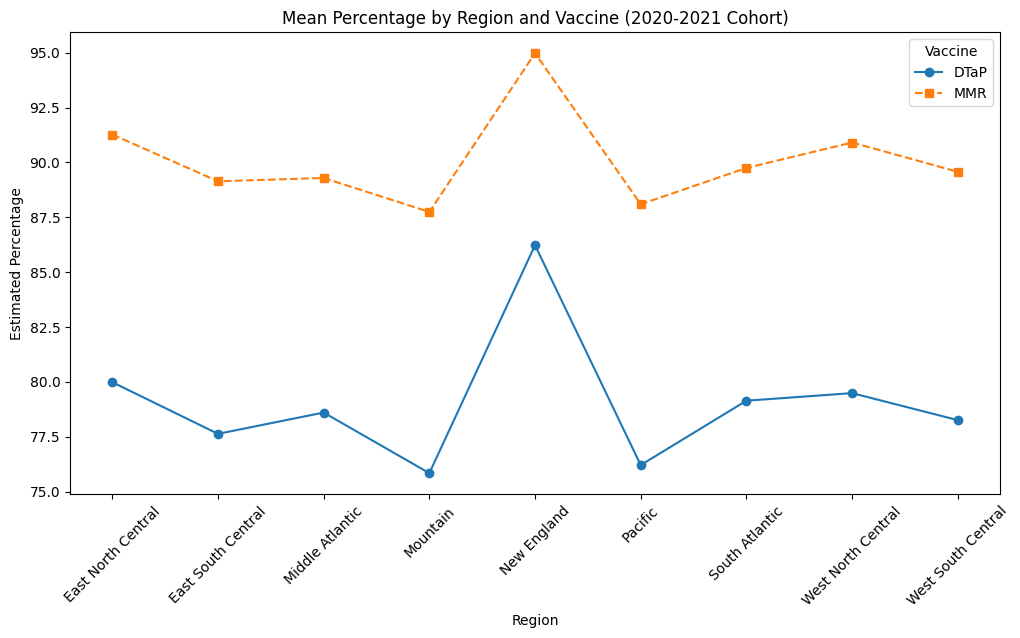

In [ ]:


# Calculate the mean 'Estimated Percentage' for each Region and Vaccine combination
means = df_filtered.groupby(['Region', 'Vaccine'])['Estimated_Percentage'].mean().reset_index()

# Separate the data by Vaccine for plotting
dtap_means = means[means['Vaccine'] == 'DTaP']
mmr_means = means[means['Vaccine'] == '≥1 Dose MMR']

# Plot the mean Estimated Percentage by Region for each Vaccine type
plt.figure(figsize=(12, 6))

# Plot DTaP means
plt.plot(dtap_means['Region'], dtap_means['Estimated_Percentage'], marker='o', linestyle='-', label='DTaP')

# Plot MMR means
plt.plot(mmr_means['Region'], mmr_means['Estimated_Percentage'], marker='s', linestyle='--', label='MMR')

# Customize the plot
plt.title('Mean Percentage by Region and Vaccine (2020-2021 Cohort)')
plt.xlabel('Region')
plt.ylabel('Estimated Percentage')
plt.xticks(rotation=45)
plt.legend(title='Vaccine')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


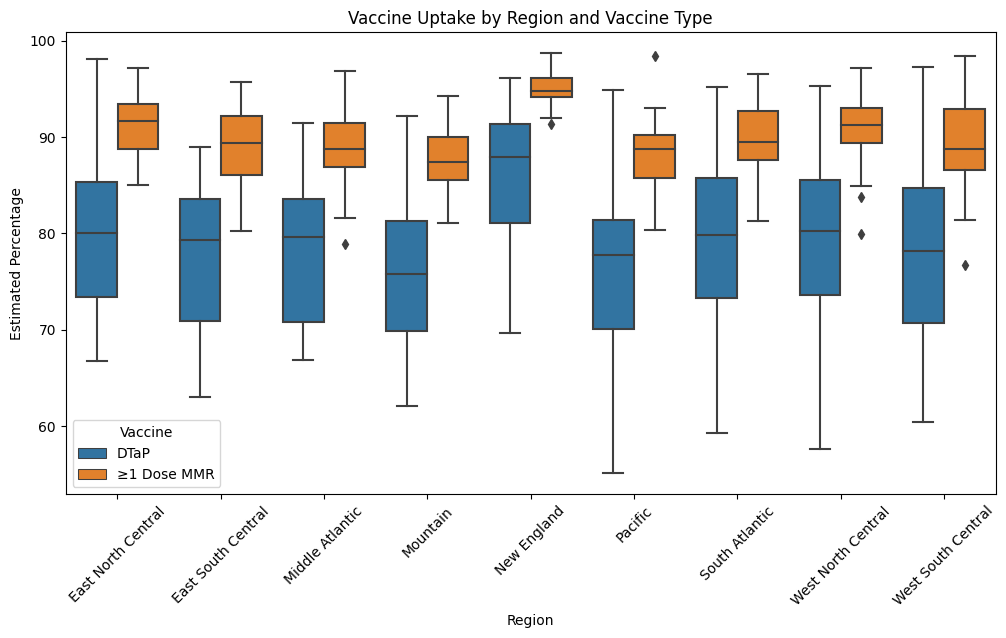

In [13]:


#BOXPLOT VISUALIZATION: 
# Create a boxplot to visualize the 'Estimated_Percentage' by 'Region' and 'Vaccine'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Region', y='Estimated_Percentage', hue='Vaccine', data=df_filtered)

# Customize the plot
plt.title('Vaccine Uptake by Region and Vaccine Type')
plt.xlabel('Region')
plt.ylabel('Estimated Percentage')
plt.xticks(rotation=45)
plt.legend(title='Vaccine')
plt.show()


In [11]:
# Tukey test for Region
tukey_region = pairwise_tukeyhsd(
    endog=df_filtered['Estimated_Percentage'],  # Dependent variable
    groups=df_filtered['Region'],              # Grouping variable
    alpha=0.01                                 # Significance level
)

print(tukey_region)
# Assuming `tukey_result` is the output of `pairwise_tukeyhsd`
tukey_df = pd.DataFrame(data=tukey_region.summary().data[1:], columns=tukey_region.summary().data[0])


             Multiple Comparison of Means - Tukey HSD, FWER=0.01             
      group1             group2       meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------
East North Central East South Central  -2.2437 0.6545  -6.6319  2.1446  False
East North Central    Middle Atlantic  -1.6825 0.7944  -5.4248  2.0597  False
East North Central           Mountain  -3.8381 0.0046  -7.4615 -0.2147   True
East North Central        New England   4.9758 0.0002   1.0807  8.8709   True
East North Central            Pacific  -3.4781 0.0583  -7.5776  0.6214  False
East North Central     South Atlantic   -1.185 0.9545  -4.7133  2.3432  False
East North Central West North Central  -0.4317    1.0   -4.174  3.3105  False
East North Central West South Central  -1.7135 0.7774  -5.4558  2.0288  False
East South Central    Middle Atlantic   0.5611 0.9999  -3.8271  4.9493  False
East South Central           Mountain  -1.5944 0.9194  -5.8818  

In [12]:
# Display significant results
significant_results = tukey_df[tukey_df['reject'] == True]


print(significant_results)

                group1              group2  meandiff   p-adj    lower  \
2   East North Central            Mountain   -3.8381  0.0046  -7.4615   
3   East North Central         New England    4.9758  0.0002   1.0807   
10  East South Central         New England    7.2194  0.0000   2.7002   
16     Middle Atlantic         New England    6.6583  0.0000   2.7633   
21            Mountain         New England    8.8139  0.0000   5.0328   
26         New England             Pacific   -8.4539  0.0000 -12.6933   
27         New England      South Atlantic   -6.1608  0.0000  -9.8507   
28         New England  West North Central   -5.4075  0.0000  -9.3026   
29         New England  West South Central   -6.6893  0.0000 -10.5844   

      upper  reject  
2   -0.2147    True  
3    8.8709    True  
10  11.7387    True  
16  10.5534    True  
21  12.5949    True  
26  -4.2145    True  
27  -2.4709    True  
28  -1.5125    True  
29  -2.7942    True  


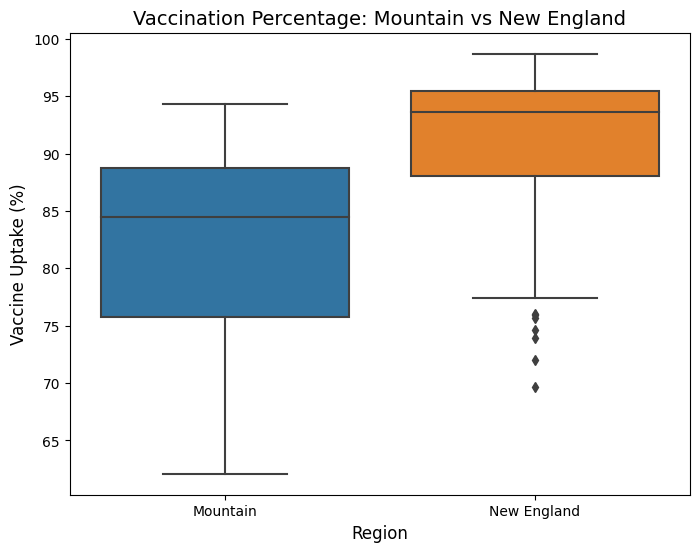

In [ ]:

###  Mountain and New England regions: mean diff is the greatest at 8.139 among any
    # 2 regions. CI of 5.0328 to 12.5949 indicates difference is real and not by random chance,
    # as interval does not include 0. Reject = True, difference is statistically significant.




# Filter the dataframe to only include Mountain and New England regions
df_tukey_comparison = df_filtered[df_filtered['Region'].isin(['Mountain', 'New England'])]

# Create the boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(x='Region', y='Estimated_Percentage', data=df_tukey_comparison, order=['Mountain', 'New England'])

# Title and labels
plt.title('Vaccination Percentage: Mountain vs New England', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Vaccine Uptake (%)', fontsize=12)

# Show the plot
plt.xticks(rotation=0)  # Ensure x-axis labels are clear
plt.show()

  Multiple Comparison of Means - Tukey HSD, FWER=0.01   
group1    group2   meandiff p-adj  lower   upper  reject
--------------------------------------------------------
  DTaP ≥1 Dose MMR  11.0296   0.0 10.0039 12.0554   True
--------------------------------------------------------


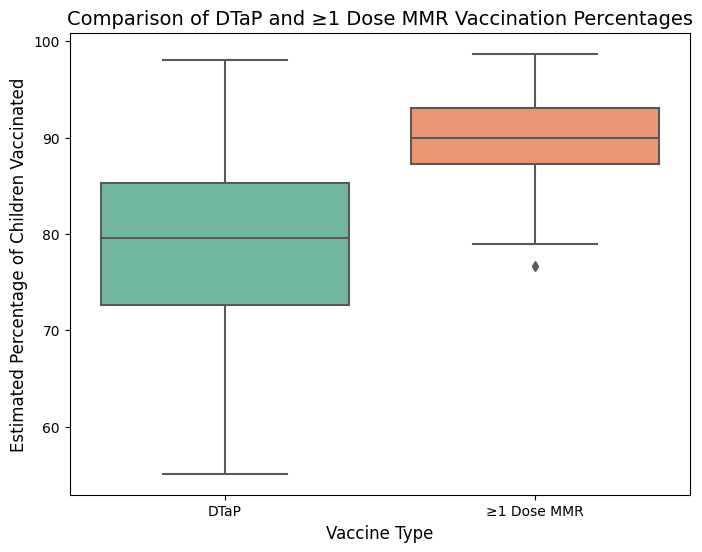

In [ ]:
# Tukey test for Vaccine
tukey_vaccine = pairwise_tukeyhsd(
    endog=df_filtered['Estimated_Percentage'],  # Dependent variable
    groups=df_filtered['Vaccine'],             # Grouping variable
    alpha=0.01                                 # Significance level
)

# Print Tukey test summary for Vaccine
print(tukey_vaccine)


# Filter your data for the two vaccines (DTaP and ≥1 Dose MMR)
filtered_data = df_filtered[df_filtered['Vaccine'].isin(['DTaP', '≥1 Dose MMR'])]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_data, x='Vaccine', y='Estimated_Percentage', palette='Set2')

# Adding titles and labels
plt.title('Comparison of DTaP and ≥1 Dose MMR Vaccination Percentages', fontsize=14)
plt.xlabel('Vaccine Type', fontsize=12)
plt.ylabel('Estimated Percentage of Children Vaccinated', fontsize=12)

# Show plot
plt.show()


In [ ]:
    ### "The Tukey HSD test for DTaP and ≥1 Dose MMR across the 9 regions 
    # revealed a statistically significant difference in the vaccination 
    # percentage between the two most contrasting regional groups: Mountain VS New England.
    # Similarly, it also showed a statistically significant difference in the
    # vaccination percentage between the two vaccine types: DTaP and MMR (at 
    # both their maximum dosages allowed at the given age range, which is 4 doses for
    # DTaP and 1 dose for MMR)
